# CNN

This notebook provides scripts that load data, create spectrogram datasets and test a CNN classifier on it

## Load Package & Initialization

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

from load_dataset import load_from_path
from spectrogram import get_class_spectrograms, save_spectrograms
from plot import plot_spectrogram, plot_fold_accuracies, plot_learning_curve

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [3]:
seed = 0
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

### Data Loading & Filtering
Function load_from_path is pre-defined to perform all data loading tasks together

In [4]:
data_path = "../Data/AllFishCombined_filtered.csv"
df = load_from_path(data_path, ['LT', 'SMB'], ['LT008', 'LT016', "SMB009"])

In [5]:
df.head()

,fishNum,Spe,Index,Ping_time,F45,F45.5,F46,F46.5,F47,F47.5,...,F255.5,F256,F256.5,F257,F257.5,F258,F258.5,F259,F259.5,F260
288,LT001,LT,1,20:57:29.4800,-36.179106,-36.156327,-36.151127,-35.777926,-35.799611,-35.608905,...,-22.723915,-22.488092,-22.628031,-22.622146,-22.040287,-20.768744,-19.238734,-17.748017,-17.375191,-17.471192
289,LT001,LT,1,20:57:29.6040,-36.436682,-36.318622,-36.159983,-35.669801,-35.567145,-35.251859,...,-14.608002,-13.226696,-12.105007,-11.121532,-10.518247,-10.105918,-9.615784,-8.770490,-8.107607,-7.145183
290,LT001,LT,1,20:57:29.7290,-36.143429,-35.675405,-35.183430,-34.451909,-34.228203,-33.938008,...,-23.780087,-21.908773,-19.930888,-18.070377,-16.854067,-16.172496,-15.871727,-15.763491,-15.611684,-13.941423
291,LT001,LT,1,20:57:29.8560,-34.455303,-34.397209,-34.375414,-34.086497,-34.233998,-34.328222,...,-36.139492,-34.982741,-34.258071,-34.247907,-35.577816,-38.674431,-45.200419,-45.788053,-37.204571,-32.093674
292,LT001,LT,1,20:57:29.9910,-40.787544,-41.273102,-41.783685,-41.943936,-42.432228,-42.722720,...,-26.510093,-27.092194,-27.751359,-27.619687,-26.436497,-24.837284,-23.678143,-22.888074,-22.871880,-22.493051


## Spectrogram Construction
Construct the spectrograms from dataset using pre-defined function

In [6]:
# Define parameters
desired_length = 50     # Number of rows to use for each spectrogram
number_per_class = 200  # Number of spectrograms to generate for each species

In [7]:
# Generate spectrograms for each target species
specs_LT = get_class_spectrograms(df, "LT", desired_length, number_per_class, seed)
specs_SMB = get_class_spectrograms(df, "SMB", desired_length, number_per_class, seed)

Visialize examples of spectrograms

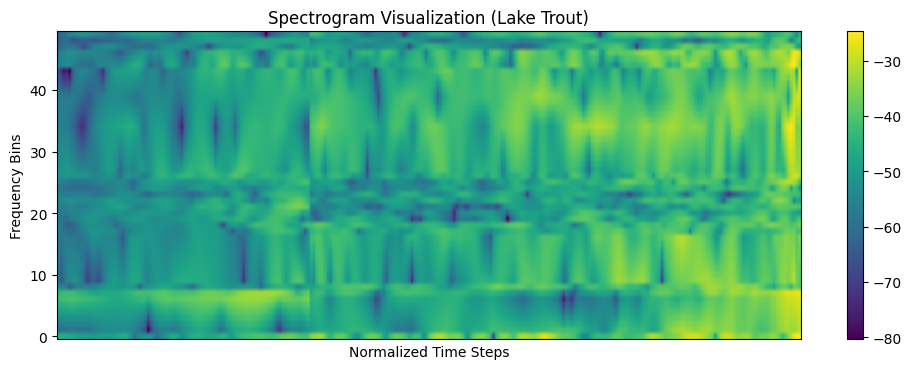

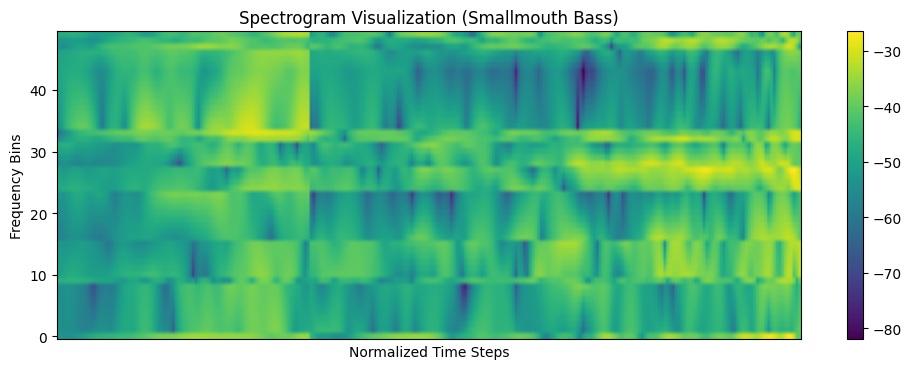

In [8]:
plot_spectrogram(specs_LT[0], "Spectrogram Visualization (Lake Trout)")
plot_spectrogram(specs_SMB[0], "Spectrogram Visualization (Smallmouth Bass)")

### Convert the spectrograms into torch tensors for model to use

In [9]:
# Stack and create labels (0 for LT, 1 for SMB)
X_LT = np.stack(specs_LT, axis=0)   # shape: (number_per_class, desired_length, num_freqs)
X_SMB = np.stack(specs_SMB, axis=0)
X_all = np.concatenate([X_LT, X_SMB], axis=0)
y_all = np.concatenate([np.zeros(len(X_LT)), np.ones(len(X_SMB))], axis=0)

In [10]:
# Add channel dimension for PyTorch (N, 1, H, W)
X_all = X_all[:, np.newaxis, :, :]  # H = desired_length, W = number of frequency columns
num_freqs = X_all.shape[3]

# Convert to torch tensors
X_tensor = torch.tensor(X_all, dtype=torch.float32)
y_tensor = torch.tensor(y_all, dtype=torch.long)

print("Data shape:", X_tensor.shape)
print("Data stats: ", torch.min(X_tensor), torch.max(X_tensor), torch.mean(X_tensor))
print("Labels shape:", y_tensor.shape)

Data shape: torch.Size([400, 1, 50, 265])
Data stats:  tensor(-106.9445) tensor(-2.0675) tensor(-46.2673)
Labels shape: torch.Size([400])


After converting to tensor, the spectrogram still preserve the same shape

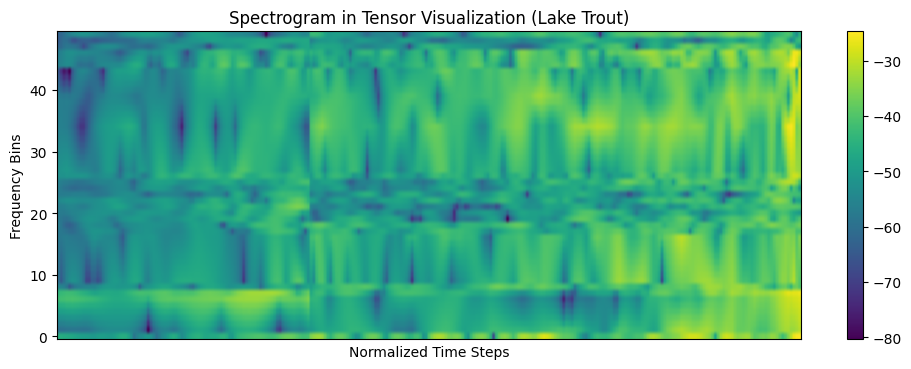

In [11]:
plot_spectrogram(X_tensor[0,0], "Spectrogram in Tensor Visualization (Lake Trout)")

## Model Setup
### Define a PyTorch CNN classifier

In [12]:
class CNNClassifier(nn.Module):
    def __init__(self, num_freqs):
        super(CNNClassifier, self).__init__()
        # First convolution: input channels 1, output 16
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        # Second convolution: from 16 to 32 channels
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Pooling layer (2x2 max pooling)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Calculate the size after two pooling layers
        # Assuming desired_length and num_freqs are divisible by 4; if not, use floor division.
        self.flat_dim = 32 * (desired_length // 4) * (num_freqs // 4)
        self.fc1 = nn.Linear(self.flat_dim, 64)
        self.fc2 = nn.Linear(64, 2)  # Binary classification: 2 classes

    def forward(self, x):
        # x shape: (batch, 1, desired_length, num_freqs)
        x = self.pool(torch.relu(self.conv1(x)))  # -> (batch, 16, H/2, W/2)
        x = self.pool(torch.relu(self.conv2(x)))  # -> (batch, 32, H/4, W/4)
        x = x.view(x.size(0), -1)                 # flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


### Define Training Parameters and KFold

In [13]:
fold_accuracies = []
all_fold_train_losses = []  # to store training losses per epoch for each fold
all_fold_val_losses = []    # to store validation losses per epoch for each fold
num_epochs = 50  
learning_rate = 0.0005

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)

## Model Training

In [14]:
for fold, (train_index, val_index) in enumerate(skf.split(X_tensor, y_tensor)):
    # print(f"\nFold {fold+1}")
    # Split into training and validation sets
    X_train, X_val = X_tensor[train_index], X_tensor[val_index]
    y_train, y_val = y_tensor[train_index], y_tensor[val_index]
    
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    
    # Initialize the model, loss, and optimizer
    model = CNNClassifier(num_freqs).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
    # Uncomment to use Adam instead:
    # optimizer = optim.Adam(model.parameters(), lr=0.001)    
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
        epoch_train_loss = running_loss / len(train_dataset)
        train_losses.append(epoch_train_loss)
        
        # Evaluate on validation set and compute loss
        model.eval()
        running_val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_val_loss += loss.item() * inputs.size(0)
        epoch_val_loss = running_val_loss / len(val_dataset)
        val_losses.append(epoch_val_loss)
        
        # print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {epoch_train_loss:.4f} - Val Loss: {epoch_val_loss:.4f}")
    
    all_fold_train_losses.append(train_losses)
    all_fold_val_losses.append(val_losses)
    
    # Evaluate accuracy on validation set
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")
    fold_accuracies.append(acc)

avg_accuracy = np.mean(fold_accuracies)
print(f"Average CV Accuracy: {avg_accuracy:.4f}")

Fold 1 Accuracy: 0.9250
Fold 2 Accuracy: 0.9250
Fold 3 Accuracy: 0.9000
Fold 4 Accuracy: 0.9000
Fold 5 Accuracy: 0.8750
Average CV Accuracy: 0.9050


### Results Plotting
Plot the training-validation loss curves

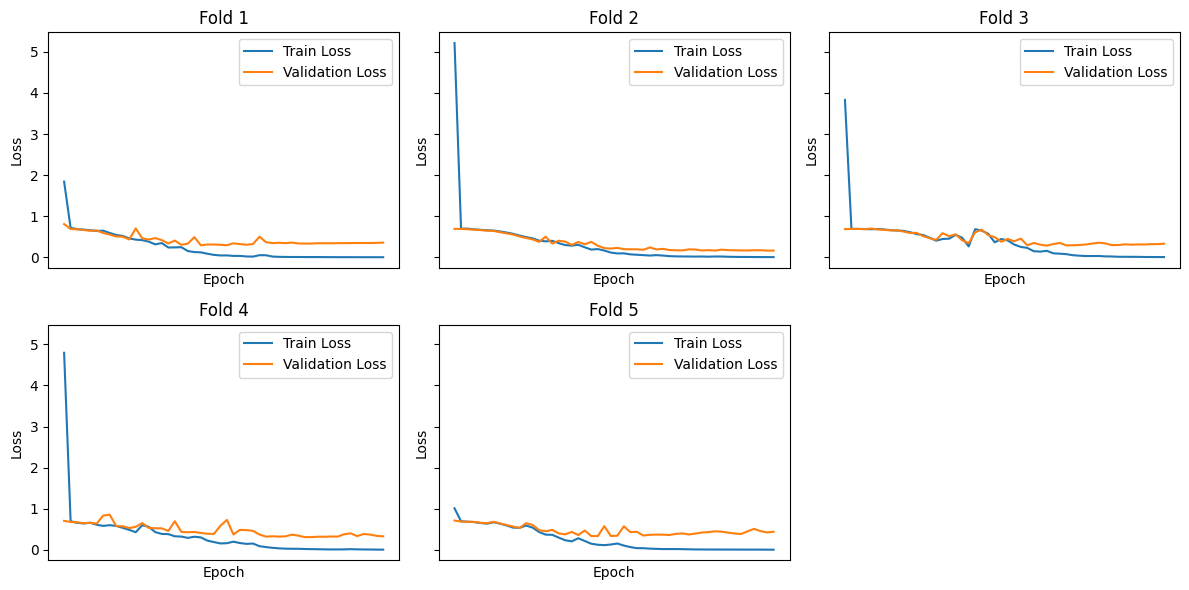

In [15]:
fig, axes = plt.subplots(2, 3, figsize=(12, 6), sharey=True)
axes = axes.ravel()

for fold in range(5):
    plot_learning_curve(axes[fold], all_fold_train_losses[fold], all_fold_val_losses[fold], fold+1)
if len(axes) > 5:
    axes[5].axis('off')

plt.tight_layout()
plt.show()

Plot the accuracies for each fold

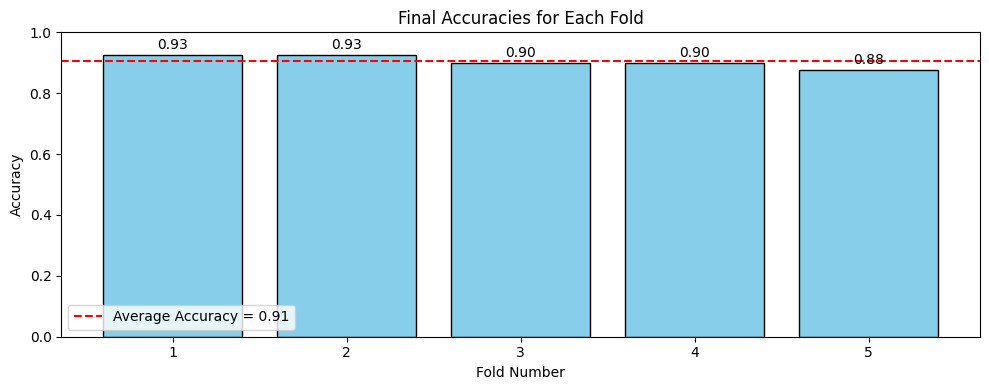

In [16]:
plot_fold_accuracies(fold_accuracies)

### Save model and spectrograms
The model and spectrogram generated can be save for future use. Omitted for the purpose this notebook

In [17]:
# To save the model:
# torch.save(model.state_dict(), "cnn_model.pth")

# Later, to load the model:
# model = CNNClassifier(num_freqs)  # Recreate the architecture
# model.load_state_dict(torch.load("cnn_model.pth"))
# model.eval()  # Set to evaluation mode


In [18]:
# To save the spectrograms of given classes and numbers:
# save_spectrograms(specs_LT, prefix="LT_sample_", num_to_save=10)